## Assignment 7 
### Feature selection

In this assignment, the HTRU2 dataset is used that can be found on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HTRU2).

In this workbook, feature selection techniques are implemented.
To minimize the work, all models that are trained in this workbook are XGBoost classifier. No other combinations of features/models are tested to find the best scoring one. Also, with every feature selection technique the dimensionality of the predictor variables is reduced to half (4 features selected). Last, a model is trained will all features and the results are compared.

### Introduction
Introduction can be found on asgmt7_feat_importance_afoudouli.ipynb

In [23]:
# if needed install packages uncommenting the following commands
#!pip install mlxtend
#!pip install Boruta

In [24]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from xgboost import XGBClassifier
from boruta import BorutaPy
import matplotlib.pyplot as plt
import os 

os.chdir('C:/Users/anast/OneDrive/Desktop/MSc/MachineLearning/Assignments/Asgmt7_FeatureSelection/')

In [8]:
data_file = 'HTRU2/HTRU_2.csv'

data = pd.read_csv(data_file, header=None)


feature_names = ["Mean of the integrated profile",
	"Standard deviation of the integrated profile",
	"Excess kurtosis of the integrated profile",
	"Skewness of the integrated profile",
	"Mean of the DM-SNR curve",
	"Standard deviation of the DM-SNR curve",
	"Excess kurtosis of the DM-SNR curve",
	"Skewness of the DM-SNR curve"]

data.columns = feature_names + ["target_class"]

In [9]:
# split in train-test set in a stratified manner
X = data.drop(columns = 'target_class')
y = data['target_class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=556, stratify=y)

In [10]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

** Feature Selection **
As the name suggests, feature selection is the process of selecting the most _significant_ and_relevant_ features from a vast set of features in the given dataset. It is a crusial component in ML and data science workflows, especially when dealing with high-dimensional data.  
Feature selections helps finding the smallest set of features, thus resulting in: 
* training any ML algorithm faster
* reducing the complexity of a model, making it easier to interpret
* reducing over-fitting by selecting the right set of features

** Filter Method ** 
 
Statistical tests can be used to select those features that have the strongest relationship with the output variable.  
In this method, as the name suggests, we are filtering the dataset and select only a subset of the available features. The selection of features is independent of any machine learning algorithm. Features give rank on the basis of statistical scores which tend to determine the features' correlation with the outcome variable. Correlation is a heavily contextual term, and it varies from work to work.  

Example methods: Correlation coefficient scores (like Pearson's correlation), chi-squared test, information gain

In [11]:
test = SelectKBest(score_func=chi2, k=4)
X_filter = test.fit_transform(X_train, y_train)
print('Selected variables are positioned at:', test.get_support(indices=True))

Selected variables are positioned at: [2 3 4 5]


** Wrapper Methods ** 

In wrapper methods, the feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset.

These methods are called greedy algorithms, as they evaluate all the possible combinations of features against the evaluation criterion. The evaluation criterion is simply the performance measure which depends on the type of problem, for e.g. For regression evaluation criterion can be p-values, R-squared, Adjusted R-squared, similarly for classification the evaluation criterion can be accuracy, precision, recall, f1-score, etc. Finally, it selects the combination of features that gives the optimal results for the specified machine learning algorithm.

In [12]:
sfs = SFS(XGBClassifier(),
          k_features=4,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 5)
sfs.fit(X_train, y_train)
print('Selected variables using forward selection are at positions:', sfs.k_feature_names_)

Selected variables using forward selection are at positions: ('0', '1', '2', '4')


In [13]:
sfs = SFS(XGBClassifier(),
          k_features=4,
          forward=False,
          floating=False,
          scoring = 'r2',
          cv = 5)
sfs.fit(X_train, y_train)
print('Selected variables using backward selection are at positions:', sfs.k_feature_names_)

Selected variables using backward selection are at positions: ('0', '2', '3', '5')


_We can use the same python code to find the optimal number of features and not directly specifying to keep only 4. The resulting model performance is ploted._

In [14]:
sfs = SFS(XGBClassifier(),
          k_features=(2,8),
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 5)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  

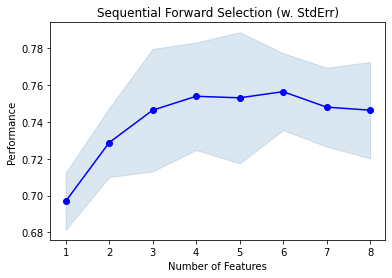

In [15]:
plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)');

** Recursive feature elimination **

In [16]:
clf = XGBClassifier()

trans = RFE(clf, n_features_to_select=4)
X_rfe = trans.fit_transform(X_train, y_train)

print('Selected features using RFE are on positions:', [x for x,y in enumerate(trans.get_support()) if y])

Selected features using RFE are on positions: [2, 4, 5, 6]


In [17]:
clf = XGBClassifier(n_jobs=-1)

trans = RFECV(clf, cv=5, n_jobs=-1, scoring='recall')
X_rfecv = trans.fit_transform(X_train, y_train)

print('Selected features using RFE are on positions:', [x for x,y in enumerate(trans.get_support()) if y])

Selected features using RFE are on positions: [1, 2, 4, 5, 6, 7]


In [18]:
trans.ranking_

array([2, 1, 1, 3, 1, 1, 1, 1])

** Boruta **


Boruta is a smart algorithm for feature selection.  
In Boruta, features do not compete among themselves. Instead they compete with a randomized version of them. Starting from X, another table is created by randomly shuffling each feature. These permuted features are called **shadow features**. The table is then merged with the orginal dataset. Then a tree-based algorithm (like **random forest**) is fitted on the merged table and the target variable. The importance of each feature is calculated and compared with a **threshold**. Τhe threshold is defined as the highest feature importance recorded among the shadow features. When the importance of a feature is higher than this threshold, this is called a “hit”. The idea is that a feature is useful only if it’s capable of doing better than the best randomized feature. The same process is iterated multiple times. A criterion is also needed, to decide how many times a feature needs to appear as a hit. The maximum level of uncertainty about the feature is expressed by a probability of 50%, like tossing a coin. Since each independent experiment can give a binary outcome (hit or no hit), a series of n trials follows a binomial distribution. We can then use statistics to decide from the distribution. Depending on the number of appearances as hit variables, a variable may be **rejected**, **confirmed** or **tentative**.

Fun fact1: The algorithm started as an [R package](https://www.jstatsoft.org/article/view/v036i11)!   
Fun fact2: Took me 3 years to finaly run Boruta since first reading for the method. :(

Great documentation can be found on [GitHub](https://github.com/scikit-learn-contrib/boruta_py).

In [30]:
clf = XGBClassifier(n_jobs=-1)

selector = BorutaPy(clf, 
                    n_estimators='auto', 
                    random_state=234, 
                    #verbose=2
                    )
selector.fit(X_train, y_train)

X_boruta = selector.transform(X_train)

print('Selected features using Boruta are on positions:', [x for x,y in enumerate(selector.support_) if y])
#selector.ranking_

Selected features using Boruta are on positions: [0, 1, 2, 4, 5, 6, 7]
